# Compute spectral ratio of the nearest sensor with the source.

This notebook performs the spectral ratio analysis to investigate the measurement resolution of GP events.

2024.10.31 Kurama Okubo

- 2024.11.18 update processing parameters. Clean up the figures.
- 2025.03.24 update for master plot. Apply a two-way high-pass filter and process 33 GP events from the original 44 after thresholding out events that do not fit the STF. We follow Lengliné et al. (2014) Fig. 8 to show the difference in corner frequency between the small and large events.

Code cleanup and optimization supported by ChatGPT.


In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import matplotlib.ticker as mticker
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from obspy.core.utcdatetime import UTCDateTime    
from tqdm import tqdm
import warnings
import time
import pickle 
import seaborn as sns

%load_ext autoreload
%autoreload 2

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = False

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = False

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision


In [2]:
figdir = "../figure/"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [3]:
# channel table
channel_finame = '../../AEchanneltable/AEsensorlocation_onFB03_table.csv'

# datadir
data_inputdir = '../../../SourceInvFit/data/04_AE_obs_isocoord'

In [4]:
# Read Channel Index
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
AEsensors = list(channel_loc.keys())
# channel_loc

# Load source parameters

In [5]:
# # load best parameters
# bestfitsourceparam_finame = f"../../../SourceInvFit/data/datacsv/gridsearch_bestparam_M0andTR_fb03-087.csv"
# df_bestparam = pd.read_csv(bestfitsourceparam_finame, index_col=0) # from waveform inversion
# df_bestparam.head()

In [6]:
# read event catalog
Nvalidsensors_thresh = 4
df_events = pd.read_csv("../../../GougeEventCatalog/data/gougeeventcatalog__fb03-087__G3__Q50.csv", index_col=0)
df_selected = df_events[df_events["Nvalidsensors"] >= Nvalidsensors_thresh]
print(len(df_selected))
df_selected.head()

33


,location,event_onset_time,stickslip_id,event_label,Q_correction_quart,Nvalidsensors,M0,M0_std,Mw,Tw,Tw_std
event_id,,,,,,,,,,,
4,1.75,42.474772,3,A,50,4,0.592607,0.178671,-6.218156,0.000003,1.530315e-07
9,1.75,47.662693,5,F,50,4,0.046991,0.007419,-6.951990,0.000002,3.643121e-07
18,1.75,56.727044,8,F,50,4,0.755830,0.192507,-6.147717,0.000003,3.100882e-07
19,1.75,59.103175,9,F,50,4,0.055755,0.016951,-6.902476,0.000002,2.699155e-07
20,1.75,59.103526,9,F,50,4,0.865466,0.210250,-6.108500,0.000003,1.352659e-07


In [7]:
eventid_sorted = df_selected.sort_values(by="M0", ascending=False).index

In [8]:
datacases_sorted = [f"fb03-087__{x:04d}" for x in eventid_sorted]

In [9]:
len(datacases_sorted)

33

In [10]:
datacases_sorted

['fb03-087__0088',
 'fb03-087__0129',
 'fb03-087__0031',
 'fb03-087__0095',
 'fb03-087__0020',
 'fb03-087__0099',
 'fb03-087__0072',
 'fb03-087__0120',
 'fb03-087__0077',
 'fb03-087__0027',
 'fb03-087__0018',
 'fb03-087__0061',
 'fb03-087__0131',
 'fb03-087__0100',
 'fb03-087__0109',
 'fb03-087__0004',
 'fb03-087__0062',
 'fb03-087__0089',
 'fb03-087__0085',
 'fb03-087__0052',
 'fb03-087__0050',
 'fb03-087__0038',
 'fb03-087__0069',
 'fb03-087__0040',
 'fb03-087__0043',
 'fb03-087__0118',
 'fb03-087__0044',
 'fb03-087__0024',
 'fb03-087__0019',
 'fb03-087__0009',
 'fb03-087__0021',
 'fb03-087__0126',
 'fb03-087__0128']

# Load the waveforms

We load the raw waveforms recorded by the sensor closest from the gouge patch G3.

In [11]:
gougepatch_id = "G3"

repeated_sensor = "OL23" #"OL23" # closest sensor from P3

st = Stream()
for datacase in datacases_sorted:
    gougeevent_id = int(datacase.split("__")[1])
    tr = read(data_inputdir+f"/obs_isocoord_{repeated_sensor}__{datacase}.pickle", format="PICKLE")[0] # This is the raw waveform before the instrumental response removal
    tr.stats.event_id = gougeevent_id
    st.append(tr)

In [12]:
st

33 Trace(s) in Stream:

FB.OL23..Z | 2023-05-29T00:02:41.09713600Z - 2023-05-29T00:02:41.09744600Z | 10000000.0 Hz, 3101 samples
...
(31 other traces)
...
FB.OL23..Z | 2023-05-29T00:04:01.51284000Z - 2023-05-29T00:04:01.51315000Z | 10000000.0 Hz, 3101 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [13]:
# compute average source distance
dist_all = []
for tr in st:
    dist_all.append(tr.stats.dist)

dist = np.mean(dist_all)
dist

96.37174641664696

# Apply high-pass filter

We apply the high-pass filter, but is used just for the plotting without the low-frequency noisee.

In [14]:
# Parameters for filtering
# We use the same filter as the previously analyzed gouge events
freqmin = 0.1e6 # apply highpass
# freqmax = 2e6 #

butterworth_order = 3

In [15]:

# sos = signal.butter(butterworth_order, freqmin, 'highpass', fs=st[0].stats.sampling_rate, output='sos')
b, a = signal.butter(butterworth_order, freqmin, 'highpass', fs=st[0].stats.sampling_rate, output='ba')

print(f"{freqmin/1e3} kHz high-pass filter.")

st_filtered = Stream()

for i, datacase in enumerate(datacases_sorted):
    gougeevent_id = int(datacase.split("__")[1])
    tr_ind = [x.stats.event_id for x in st].index(gougeevent_id)
    tr_obs_raw = st[tr_ind]
    assert(tr_obs_raw.stats.event_id == gougeevent_id)
    # using sos to minimize the numerical error of filter
    tr_obs_filtered = tr_obs_raw.copy().taper(0.05)
    # tr_obs_filtered.data = signal.sosfilt(sos, tr_obs_filtered.data)
    tr_obs_filtered.data = signal.filtfilt(b, a, tr_obs_filtered.data, method='gust') # two-way filter 
    st_filtered.append(tr_obs_filtered)

100.0 kHz high-pass filter.


Text(0, 0.5, 'Count')

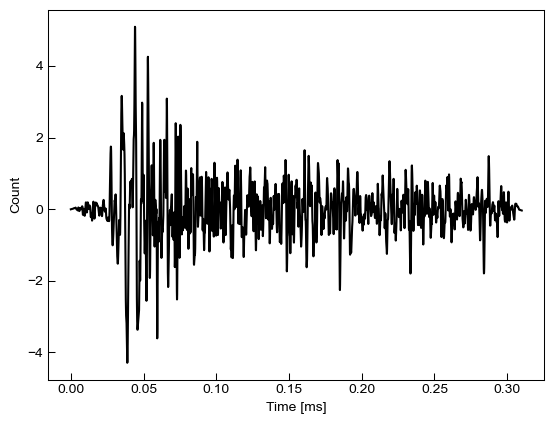

In [16]:
tr_test = st_filtered[0]
plt.plot(tr_test.times()*1e3, tr_test.data, "k-")
plt.xlabel("Time [ms]")
plt.ylabel("Count")

# Load onset timing

In [17]:
df_onset = pd.read_csv(f"../../../ComputeScaling/data/01_plot_gougeevents/P_repicked_onset_time_G3_{repeated_sensor}.csv", index_col=0)
datacases = list(df_onset.index)
df_onset.head()

,onset_npt,sensor,onset_t[ms],onset_d_ref[mm]
fb03-087__0088,261,OL23,0.0161,99.82
fb03-087__0129,265,OL23,0.0165,102.30
fb03-087__0031,267,OL23,0.0167,103.54
fb03-087__0095,262,OL23,0.0162,100.44
fb03-087__0020,262,OL23,0.0162,100.44


# Trim the P wave window
We use the repicked P wave onset time to trim the P wave window.

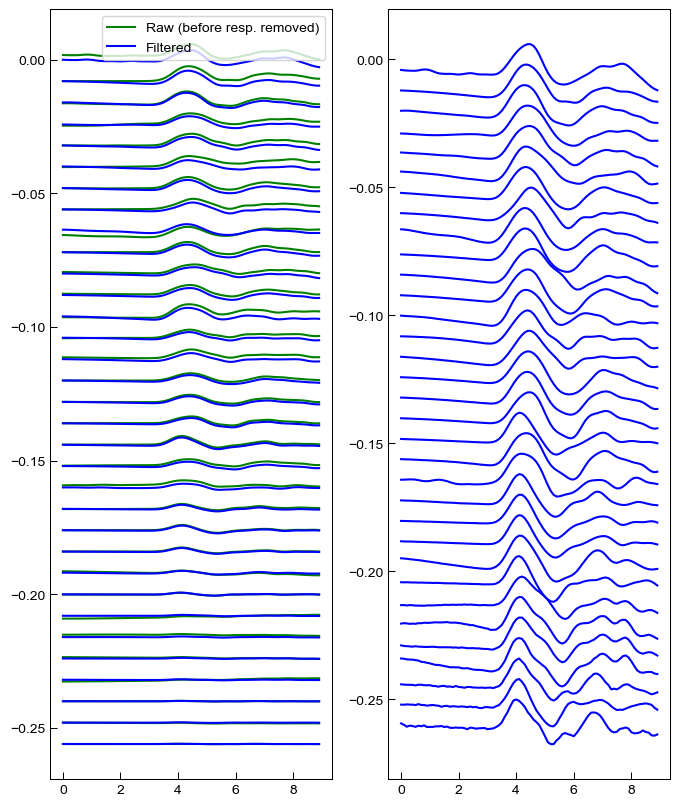

In [228]:
fig, axs = plt.subplots(1, 2, figsize=(8, 10))

raw_ampnorm = 5e2
yshift = 0
del_yshift = 4e-3

pwin_pre = 3e-6 #3e-6 # 2e-6
pwin_len = 6e-6 #6e-6 #10e-6 #10e-6

fs = st[0].stats.sampling_rate

st_obs_raw_trimmed = Stream()
st_obs_filtered_trimmed = Stream()

peak_P_amp = dict() # used for normalizing waveform amplitude

for i, datacase in enumerate(datacases_sorted):
    # i = 4
    gougeevent_id = int(datacase.split("__")[1])
    # tr_ind = [x.stats.dataindex[6:] for x in st].index(datacase)
    tr_ind = [x.stats.event_id for x in st].index(gougeevent_id)
    tr_obs_raw = st[tr_ind]
    tr_obs_filtered = st_filtered[tr_ind]
    assert(tr_obs_raw.stats.event_id == gougeevent_id)
    assert(tr_obs_filtered.stats.event_id == gougeevent_id)

    # trim P wave window
    onset_t = df_onset.loc[datacase]["onset_t[ms]"]
    onset_p_ind = df_onset.loc[datacase]["onset_npt"]
    pwin_pre_k = int(pwin_pre*fs)
    pwin_len_k = int(pwin_len*fs)
    
    tr_obs_raw_trimmed = tr_obs_raw.copy()
    tr_obs_raw_trimmed.data = tr_obs_raw.data[onset_p_ind-pwin_pre_k:onset_p_ind+pwin_len_k]

    tr_obs_filtered_trimmed = tr_obs_filtered.copy()
    tr_obs_filtered_trimmed.data = tr_obs_filtered.data[onset_p_ind-pwin_pre_k:onset_p_ind+pwin_len_k]


    # st_tmp = tr_obs_raw.stats.starttime
    pt = tr_obs_raw.stats.pretrigger*1e-3 #[s]
    # pp = tp*1e-3 #[s]
    # # Using recomputed P wave arrival time
    # tr_obs_raw_trimmed = tr_obs_raw.copy().trim(st_tmp+pt+pp-pwin_pre, st_tmp+pt+pp+pwin_len, pad=True, fill_value=0, nearest_sample=True)

    # store the trimmed timing
    tr_obs_raw_trimmed.stats.trim_st = pt+onset_t*1e-3 - pwin_pre #pt+pp-pwin_pre
    tr_obs_filtered_trimmed.stats.trim_st = pt+onset_t*1e-3 - pwin_pre #pt+pp-pwin_pre
    
    st_obs_raw_trimmed.append(tr_obs_raw_trimmed)
    st_obs_filtered_trimmed.append(tr_obs_filtered_trimmed)

    ax = axs[0]
    h2, = ax.plot(tr_obs_raw_trimmed.times()*1e6, (tr_obs_raw_trimmed.data/raw_ampnorm) - yshift, "g-", label="Raw")
    h3, = ax.plot(tr_obs_filtered_trimmed.times()*1e6, (tr_obs_filtered_trimmed.data/raw_ampnorm) - yshift, "b-", label="filtered")
    # # ax.plot(tvec-pretrigger+dt_shift_p, (tr_syn.data/ampnorm) - yshift - yspan, "r-", lw=1)
    yshift = yshift + del_yshift

    ax = axs[1]
    # Plot normalized P waves
    ampnorm = np.max(tr_obs_filtered_trimmed.data)
    peak_P_amp[datacase] = ampnorm
    # h4, = ax.plot(tr_obs_raw_trimmed.times()*1e6, (tr_obs_raw_trimmed.data/ampnorm) - yshift, "g-", label="Raw")
    h5, = ax.plot(tr_obs_filtered_trimmed.times()*1e6, (0.01 * tr_obs_filtered_trimmed.data/ampnorm) - yshift, "b-", label="filtered")
    # # ax.plot(tvec-pretrigger+dt_shift_p, (tr_syn.data/ampnorm) - yshift - yspan, "r-", lw=1)
    yshift = yshift + del_yshift


axs[0].legend([h2, h3], ["Raw (before resp. removed)", "Filtered"], loc=1)

# Plot raw data with P wave window

In [229]:
# load color dictionary consistent to the plot of the repeated waveforms
repeated_sensor_lcdict = "OL23" # the color dict is same for all the sensor although separately saved.
gougepatch_id = "G3"
with open(f'../../../ComputeScaling/data/01_plot_gougeevents/lc_dict_{gougepatch_id}_{repeated_sensor_lcdict}.pkl', 'rb') as fi:
    lc_dict = pickle.load(fi)

In [230]:
st

33 Trace(s) in Stream:

FB.OL23..Z | 2023-05-29T00:02:41.09713600Z - 2023-05-29T00:02:41.09744600Z | 10000000.0 Hz, 3101 samples
...
(31 other traces)
...
FB.OL23..Z | 2023-05-29T00:04:01.51284000Z - 2023-05-29T00:04:01.51315000Z | 10000000.0 Hz, 3101 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [231]:
tr_obs_filtered.stats

         network: FB
         station: OL23
        location: 
         channel: Z
       starttime: 2023-05-29T00:04:01.51284000Z
         endtime: 2023-05-29T00:04:01.51315000Z
   sampling_rate: 10000000.0
           delta: 1e-07
            npts: 3101
           calib: 1.0
         _format: PICKLE
            dist: 97.12395430582507
            eta1: -0.05625
        event_id: 128
      origintime: 241.51294000000001
      pretrigger: 0.01
      processing: ['ObsPy 1.4.1: trim(endtime=UTCDateTime(2023, 5, 29, 0, 4, 1, 513240)::fill_value=0.0::nearest_sample=True::pad=True::starttime=UTCDateTime(2023, 5, 29, 0, 4, 1, 512930))', "ObsPy 1.4.1: taper(max_length=None::max_percentage=0.05::side='both'::type='hann')"]
           tpick: 0.01566515392029438
       windowlen: 0.3
             xi1: 0.03699999999999992
           zeta1: 0

In [232]:
# read repicked onset P
df_onset = pd.read_csv(f"../../../ComputeScaling/data/01_plot_gougeevents/P_repicked_onset_time_G3_{repeated_sensor}.csv", index_col=0)
df_onset.loc[datacase, :]["onset_t[ms]"]

0.016

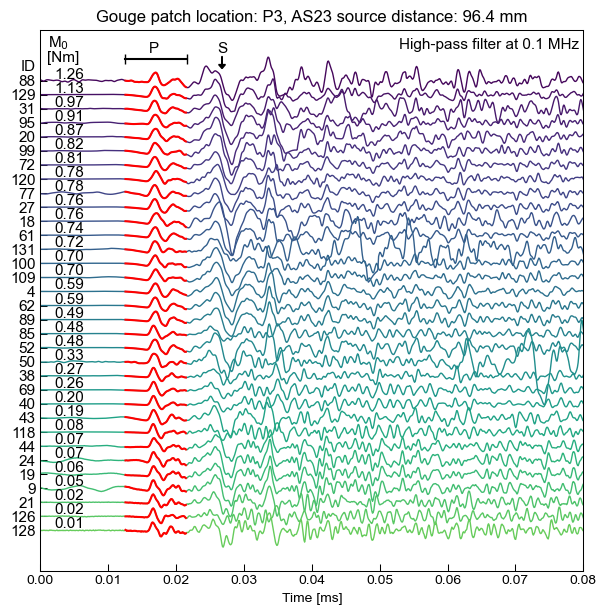

In [233]:
fig, ax = plt.subplots(1, 1, figsize=(6.2, 6.25))

selected_sensor = st_filtered[0].stats.station
tvec = st_filtered[0].times() * 1e3

cp = 6200
cs = 3600

tp = dist / cp
ts = dist / cs

yshift = 0
del_yshift = 7e-3 
ampnorm = 0.04 
ampnorm_normalized = 2.5e2 

yspan = 0
expr_id = datacases[0].split('__')[0]

pretrigger = st_filtered[0].stats.pretrigger
ytickloc = []
yticklabel = []

IfParrivalshift = True 
yshift = 0
normalize_j = 1
ifPolarityPos = False

for i, datacase in enumerate(datacases_sorted):
    gougeevent_id = int(datacase.split("__")[1])
    tr_ind = [x.stats.event_id for x in st_filtered].index(gougeevent_id)
    tr_obs_filtered = st_filtered[tr_ind]
    tr_obs_filtered_trimmed = st_obs_filtered_trimmed[tr_ind]

    assert tr_obs_filtered.stats.event_id == gougeevent_id

    ytickloc.append(-yshift)
    yticklabel.append(f"{gougeevent_id:d}")

    onset_p_t = df_onset.loc[datacase, :]["onset_t[ms]"]
    dtshift = (tp) - onset_p_t if IfParrivalshift else 0 

    ampnorm_peak_P = peak_P_amp[datacase]
    plotamp = abs(ampnorm_peak_P) * ampnorm_normalized

    polarity = -1 * np.sign(tr_obs_filtered.stats.xi1) * np.sign(channel_loc[repeated_sensor][1]) if ifPolarityPos else 1
    
    ax.plot(tvec - pretrigger + dtshift, (tr_obs_filtered.data / plotamp) - yshift, "-", lw=1, c=lc_dict[datacase])
    
    tvec_trimmed = tr_obs_filtered_trimmed.times()
    trim_st = tr_obs_filtered_trimmed.stats.trim_st
    ax.plot((tvec_trimmed + trim_st) * 1e3 - pretrigger + dtshift, (tr_obs_filtered_trimmed.data / plotamp) - yshift, "r-", label="Raw", lw=1.5)
    
    yshift += del_yshift

    M0_best = df_selected.loc[gougeevent_id, "M0"]
    ax.text(0.002, ytickloc[i] + 0.001, r"{:.2f}".format(M0_best), ha="left", fontsize=11)

ax.text(0.0026, ytickloc[0] + 0.0165, r"M$_{\mathrm{0}}$", ha="center", fontsize=11)
ax.text(0.001, ytickloc[0] + 0.0094, "[Nm]", ha="left", fontsize=11)

ax.arrow(ts, 1.2e-2, 0, -6e-3, width=5e-5, length_includes_head=True, head_length=2e-3, head_width=1.0e-3, color='k')
ax.text(ts, 1.4e-2, "S", ha="center", fontsize=11)

ax.plot([tp - pwin_pre*1e3, tp + pwin_len*1e3], [1.1e-2, 1.1e-2], "k-", marker="|", ms=7, markeredgewidth=1)
ax.text(tp, 1.4e-2, "    P", ha="center", fontsize=11)

ax.text(-0.036, 0.925, "ID", transform=ax.transAxes, fontsize=11)
ax.set_xlim([0.0, 0.08])
ax.set_ylim([ytickloc[-1] - 0.02, ytickloc[0] + 0.025])
ax.set_xlabel("Time [ms]")
ax.set_yticks(np.round(ytickloc, 3))
ax.set_yticklabels(yticklabel, fontsize=11)

title_str = f"Gouge patch location: P3, AS{selected_sensor[2:]} source distance: {dist:.1f} mm"
ax.set_title(title_str, fontsize=12)
ax.text(0.66, 0.965, f"High-pass filter at {freqmin / 1e6:g} MHz", transform=ax.transAxes, fontsize=11)

fig.tight_layout()

plt.savefig(figdir + f"/FigS_rawwaveform_noremovalresp_Ptrim_{gougepatch_id}_{repeated_sensor}.png", dpi=70)
plt.savefig(figdir + f"/FigS_rawwaveform_noremovalresp_Ptrim_{gougepatch_id}_{repeated_sensor}.eps")


In [234]:
tvec-pretrigger+dtshift

array([-0.01045617, -0.01035617, -0.01025617, ...,  0.29934383,
        0.29944383,  0.29954383])

In [235]:
pretrigger

0.01

In [236]:
dtshift

-0.0004561699327988774

In [237]:
df_selected.loc[gougeevent_id]

location                   1.75
event_onset_time      241.51294
stickslip_id                 53
event_label                   A
Q_correction_quart           50
Nvalidsensors                 4
M0                     0.012927
M0_std                   0.0022
Mw                    -7.325668
Tw                     0.000002
Tw_std                      0.0
Name: 128, dtype: object

# Compute spectra around P wave window

We follow the analysis done by Lengliné et al. (2014) Fig. 8, showing

1. Absolute value of spectra
2. Normalized spectra
3. Spectra ratio computed by the largest GP event divided by each event. 


## Compute P wave spectra
Process flow:

1. Trim around the P wave
   - We apply the demean, detrend, and apply the Tukey window to smooth the spectra
3. Compute amplitude spectra
4. Plot the spectral ratio


In [238]:
# Compute amplitude spectra
def compute_sourcespectrum_amplitudespectrum(tr, dt, N=2**10):
    """
    tr: trace with source time function
    amplitude spectrum of moment rate function propotional to the far-field displacement
    """
    F = np.fft.rfft(tr, n=N) # * dt skip normalizing spectra with dt as this is not displacement spectra to evaluate M0
    freq = np.fft.rfftfreq(N, dt)
    Xabs = np.abs(F)

    return F, Xabs, freq

def compute_sourcespectrum(freq, M0, n, fc,):
    return M0 / (1 + (freq/fc)**n)

512 90


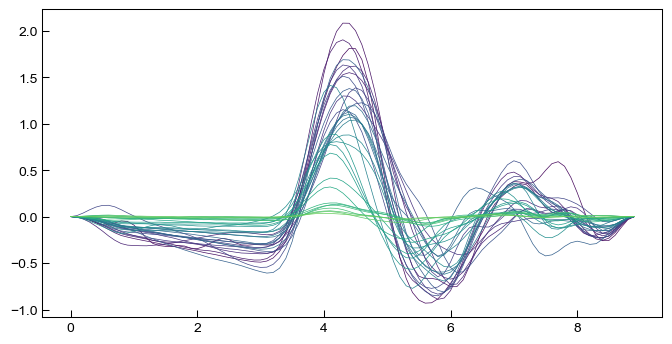

In [247]:
Freqdata_all = dict()

Nfft = 2**9
print(Nfft, st_obs_raw_trimmed[0].stats.npts)

Istapering = True #True
tukey_alpha = 0.2 #1.0

fig, ax = plt.subplots(1, 1, figsize=(8, 4))


for i, datacase in enumerate(datacases_sorted):
    
    gougeevent_id = int(datacase.split("__")[1])
    tr_ind = [x.stats.event_id for x in st_obs_raw_trimmed].index(gougeevent_id)
    tr_obs_raw_trimmed = st_obs_raw_trimmed[tr_ind]
    
    # compute amplitude spectrum
    tr_obs_raw_trimmed_detrended = tr_obs_raw_trimmed.copy().detrend("constant").detrend("linear") # demean, detrend
    window = signal.windows.tukey(tr_obs_raw_trimmed_detrended.stats.npts, alpha=tukey_alpha)
    assert tr_obs_raw_trimmed_detrended.stats.npts < Nfft
    
    if Istapering:
        tr_obs_raw_trimmed_detrended.data *= window
    
    F, Xabs, freq = compute_sourcespectrum_amplitudespectrum(tr_obs_raw_trimmed_detrended.data, tr_obs_raw_trimmed_detrended.stats.delta, N=Nfft)
#     assert((np.abs(Xabs - Xabs2[:int(Nfft/2+1)])<1e9).all()) # Check if the one-sided power spectrum is computed
    key_F = f"F_{datacase}"
    key_Fabs = f"Fabs_{datacase}"
    key_freq = f"Ffreq_{datacase}"

    Freqdata_all[key_F] = F
    Freqdata_all[key_Fabs] = Xabs
    Freqdata_all[key_freq] = freq
    
    ax.plot(tr_obs_raw_trimmed_detrended.times()*1e6, tr_obs_raw_trimmed_detrended.data, c=lc_dict[datacase], lw=0.5)

## Plot P wave spectra

In [248]:
largest_event_id = 129
target_event_ids = [126, 118, 24, 50, 52, 72]

largest_event_datacase = f"fb03-087__{largest_event_id:04d}"
target_event_datacase = [f"fb03-087__{x:04d}" for x in target_event_ids]


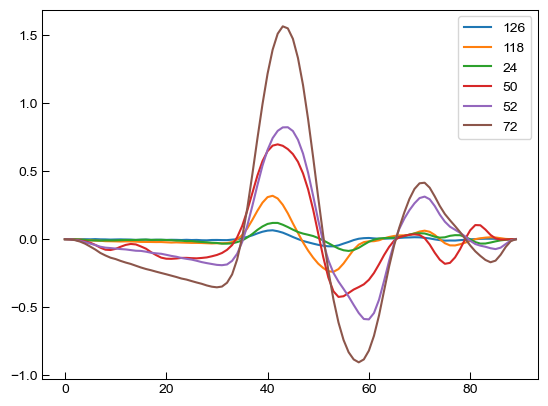

In [249]:
for i, datacase in enumerate(target_event_datacase):
    gougeevent_id = int(datacase.split("__")[1])
    tr_ind = [x.stats.event_id for x in st_obs_raw_trimmed].index(gougeevent_id)
    tr_obs_filtered_trimmed = st_obs_filtered_trimmed[tr_ind]

    tr_test = tr_obs_filtered_trimmed.copy().detrend("constant").detrend("linear") # demean, detrend
    window = signal.windows.tukey(tr_obs_filtered_trimmed.stats.npts, alpha=tukey_alpha)
    tr_test.data *= window
    
    plt.plot(tr_test.data, label=f"{gougeevent_id}")

plt.legend()

129 1.1312377
126 0.017021253
118 0.076078949
24 0.065639137
50 0.32637646
52 0.48113795
72 0.80865023


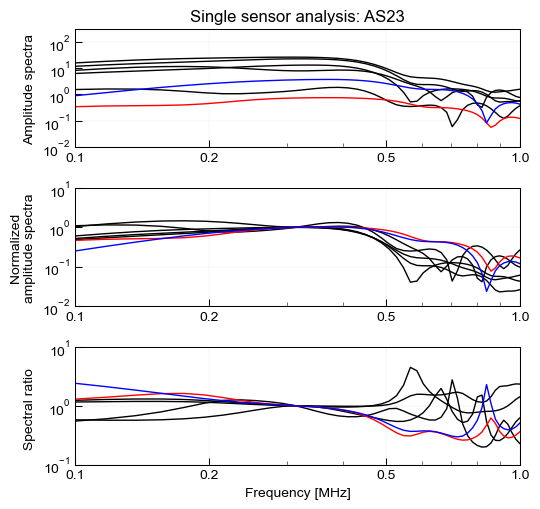

In [251]:
fig, axs =  plt.subplots(3, 1, figsize=(5.5, 5.2), sharex=False)

normalize_freq = 0.3e6 # normalize amplitude at this frequency

# extract reference spectra for largest event
key_F_ref = f"Fabs_{largest_event_datacase}"
Xabs_ref = Freqdata_all[key_F_ref]

for i, datacase in enumerate(np.hstack([largest_event_datacase, target_event_datacase])):
    gougeevent_id = int(datacase.split("__")[1])

    key_F = f"Fabs_{datacase}"
    key_freq = f"Ffreq_{datacase}"

    Xabs = Freqdata_all[key_F]
    freq = Freqdata_all[key_freq]

    M0_best = df_selected.loc[gougeevent_id, "M0"]
    print(gougeevent_id, M0_best)
    
    # Absolute spectra
    if gougeevent_id in [126]:
        lw_spec, lc, zo = 1.0, "r", 2
    elif gougeevent_id in [118]:
        lw_spec, lc, zo = 1.0, "b", 2
    else:
        lw_spec, lc, zo = 1.0, "k", 1

    # spectra noramlized by tiny event
    axs[0].loglog(freq/1e6, Xabs, "-", label=None, lw=lw_spec, c=lc, zorder=zo, )

    # 2. Normalized spectra
    freq_norm = np.where(freq>normalize_freq)[0][0]
    Xabs_norm = Xabs[freq_norm]
    axs[1].loglog(freq/1e6, Xabs/Xabs_norm, "-", label=None, lw=lw_spec, c=lc, zorder=zo, )

    # 2. Spectral ratio
    if gougeevent_id == largest_event_id:
        continue # skip the reference curve, which merely shows unity 
    else:
        specratio = Xabs_ref/Xabs
        specratio_norm = specratio[freq_norm]
        axs[2].loglog(freq/1e6, specratio/specratio_norm, "-", label=None, lw=lw_spec, c=lc, zorder=zo, )

xlimit=[0.1, 1]
ylimits=[[1e-2, 3e2], [1e-2, 10], [1e-1, 1e1]]


for i, ax in enumerate(axs):
    ax.set_xlim(xlimit)
    ax.set_ylim(ylimits[i])

    ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, which="major", zorder=0)
    ax.set_axisbelow(True)

    ax.set_xticks([0.1, 0.2, 0.5, 1.0])
    ax.set_xticklabels([0.1, 0.2, 0.5, 1.0])
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())  # Remove minor tick labels
    ax.yaxis.set_minor_locator(mticker.NullLocator())  # Remove minor tick labels

    # ax.xaxis.set_minor_formatter(mticker.FormatStrFormatter('%.1f'))
   


axs[0].set_ylabel("Amplitude spectra")
axs[1].set_ylabel("Normalized\namplitude spectra")
axs[2].set_ylabel("Spectral ratio ")
axs[2].set_xlabel("Frequency [MHz]")


axs[0].set_title(f"Single sensor analysis: AS{repeated_sensor[2:]}")

fig.align_ylabels(axs[:])

plt.tight_layout()

# axs[0].yaxis.set_minor_formatter(mticker.NullFormatter())

plt.savefig(figdir + f"/spectralanalysis_singlestation_{repeated_sensor}.png", dpi=100, bbox_inches="tight")
plt.savefig(figdir + f"/spectralanalysis_singlestation_{repeated_sensor}.eps", bbox_inches="tight")
